# Measuring Contiguity in Redistricting

In [1]:
import swat
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import cas_connection as cas
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
import libpysal as lp
from us import states
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO

### Set Up CAS

In [2]:
s = cas.reconnect()
swat.options.cas.print_messages = False
s.loadActionSet('network')

[actionset]

 'network'

+ Elapsed: 0.0023s, sys: 0.002s, mem: 0.27mb

### Data retrieval functions

Here we pull block equivalency files and block shapefiles from the US Census.  The shapefiles provide block boundaries and the equivalency files provide the assignment of blocks to districts.

In [3]:
def retrieve_block_equivalency_files():
    # congressional district assignments
    cong_bef_zip = urlopen(
        'https://www2.census.gov/programs-surveys/decennial/rdo/mapping-files/2023/118-congressional-district-bef/cd118.zip')
    cong_bef_zipfile = ZipFile(BytesIO(cong_bef_zip.read()))
    national_cong_bef = pd.read_csv(cong_bef_zipfile.open('National_CD118.txt'), dtype = 'str').rename(columns = {'CDFP':'Congressional'})

    # state legislative-upper chamber district assignments
    st_leg_upper_bef_zip = urlopen(
        'https://www2.census.gov/programs-surveys/decennial/rdo/mapping-files/2023/2022-state-legislative-bef/sldu_2022.zip')
    st_leg_upper_bef_zipfile = ZipFile(BytesIO(st_leg_upper_bef_zip.read()))
    national_st_leg_upper_bef = pd.read_csv(st_leg_upper_bef_zipfile.open('National_SLDU22.txt'), dtype = 'str').rename(columns = {'SLDUST':'ST_Leg_Upper'})

    # state legislative-lower chamber district assignments
    st_leg_lower_bef_zip = urlopen(
        'https://www2.census.gov/programs-surveys/decennial/rdo/mapping-files/2023/2022-state-legislative-bef/sldl_2022.zip')
    st_leg_lower_bef_zipfile = ZipFile(BytesIO(st_leg_lower_bef_zip.read()))
    national_st_leg_lower_bef = pd.read_csv(st_leg_lower_bef_zipfile.open('National_SLDL22.txt'), dtype = 'str').rename(columns = {'SLDLST':'ST_Leg_Lower'})
    
    return national_cong_bef, national_st_leg_upper_bef, national_st_leg_lower_bef

In [4]:
def retrieve_state_block_gdf(state_fips):
    shp_url = f'https://www2.census.gov/geo/tiger/TIGER2020PL/LAYER/TABBLOCK/2020/tl_2020_{str(state_fips)}_tabblock20.zip'
    return gpd.read_file(shp_url)

### Data Prep Functions

Here we process the block data into block adjacency graphs.

In [5]:
def prep_state_block_data_for_graph(block_gdf, cong_bef, st_leg_upper_bef, st_leg_lower_bef):
    # merge data
    block_data = block_gdf.merge(cong_bef, left_on = 'GEOID20', right_on = 'GEOID', how = 'left')
    block_data = block_data.merge(st_leg_upper_bef, left_on = 'GEOID', right_on = 'GEOID', how = 'left')
    block_data = block_data.merge(st_leg_lower_bef, left_on = 'GEOID', right_on = 'GEOID', how = 'left')
    assert(len(block_gdf) == len(block_data))
    # explode Multi Polygon Blocks
    block_polygons = block_data.explode(index_parts = True).reset_index()
    assert(block_polygons.geom_type.nunique() == 1)
    block_polygons['GEOID_poly'] = block_polygons['GEOID'].astype('str')+'_'+block_polygons['level_1'].astype('str')    
    return block_polygons

In [6]:
def get_block_graph_data(block_polygons, contig_type = 'Rook', chambers = ['Congressional','ST_Leg_Upper','ST_Leg_Lower',]):
    contig_weights = lp.weights.Queen if contig_type == 'Queen' else lp.weights.Rook
    # get block adjacencies. This may take a couple minutes
    block_neighbors = contig_weights.from_dataframe(
        block_polygons, ids = 'GEOID_poly', use_index = False)
    block_adj = block_neighbors.to_adjlist(remove_symmetric = True).rename(
        columns = {'focal': 'from', 'neighbor': 'to'})
    # add district labels to graph data
    block_adj = block_adj.merge(block_polygons[['GEOID_poly']+chambers].rename(columns = {**{'GEOID_poly':'from'},**{col:'from_'+col for col in chambers}}))
    block_adj = block_adj.merge(block_polygons[['GEOID_poly']+chambers].rename(columns = {**{'GEOID_poly':'to'},**{col:'to_'+col for col in chambers}}))
    block_nodes = block_polygons[['GEOID_poly']+chambers].rename(columns = {'GEOID_poly':'node'})
    return block_nodes, block_adj


### Determine Connected Components

Here contiguity is assessed using the connectedComponents Action from the SAS Viya Network Action Set.

In [7]:
def get_connected_components(node_data, edge_data, concomp_prefix = ''):
    s.upload(edge_data, casout = {'name':'EdgeSetIn', 'replace':True})
    s.upload(node_data, casout = {'name':'NodeSetIn', 'replace':True})
    s.network.connectedComponents(
        indexOffset    = 1,
        links          = {"name": "EdgeSetIn"},
        nodes          = {"name": "NodeSetIn"},
        outNodes       = {"name": "NodeSetOut", "replace":True},
        )
    label_nodes = s.CASTable('NodeSetIn').to_frame().merge(s.CASTable('NodeSetOut').to_frame(), on = 'node')
    return label_nodes.astype({'concomp':'int'}).rename(columns = {'concomp':f'{concomp_prefix}_concomp'})

### Label Connected Components

In order to account for natural islands, we separately label each block with both its statewide connected component and its district-level connected component within each statewide component.

In [8]:
def add_statewide_concomp(node_data, edge_data, chamber, exclude_code = None):
    if exclude_code is not None:
        node_data = node_data[node_data[chamber] != exclude_code]
        edge_data = edge_data[(edge_data['from_'+chamber] != exclude_code)&(edge_data['to_'+chamber] != exclude_code)]
    # first get statewide graph connected components to exclude natural islands
    node_data = get_connected_components(node_data, edge_data, concomp_prefix = 'statewide')
    edge_data = edge_data.merge(node_data[['node','statewide_concomp']].rename(columns = {'node':'from'}))
    return node_data, edge_data

In [9]:
def add_district_concomp(node_data, edge_data, district_col):
    # count connected components for each district in each statewide connected component
    dist_nodes_concomps = []
    for (dist, concomp), dist_nodes in node_data.groupby([district_col,'statewide_concomp']):
        dist_edges = edge_data[(edge_data['statewide_concomp'] == concomp)&(edge_data['from_'+district_col] == dist)&(edge_data['to_'+district_col] == dist)]
        dist_nodes_concomp = get_connected_components(dist_nodes, dist_edges, concomp_prefix = district_col)
        dist_nodes_concomps.append(dist_nodes_concomp)
    nodes_w_dist_concomp_labels = pd.DataFrame(pd.concat(dist_nodes_concomps))
    assert(len(nodes_w_dist_concomp_labels) == len(node_data))
    return nodes_w_dist_concomp_labels


### Get Number of Components by District

Finally we determine, for a given state and districting plan, which districts have multiple connected components within a single statewide component (i.e. are discontiguous)


In [10]:
def num_concomp_per_dist(state_block_nodes, state_block_adj,district_col,exclude_code):
    if len(state_block_nodes[~state_block_nodes[district_col].isna()]) == 0:
        return {}
    # get statewide connected components
    state_block_nodes_comp, state_block_adj_comp = add_statewide_concomp(state_block_nodes, state_block_adj, district_col, exclude_code = exclude_code)
    # how many districts have more than one connected component in a statewide connected component    
    state_dist_concomp = add_district_concomp(state_block_nodes_comp, state_block_adj_comp, district_col)
    dist_grouped = state_dist_concomp.groupby(district_col).nunique().reset_index()
    return pd.Series(dist_grouped[district_col+'_concomp'].values, index = dist_grouped[district_col]).to_dict()
    

## Example Analysis for Wisconsin

Here we demonstrate how to put the data prep and analysis components together to assess contiguity within a state. We use Wisconsin and Rook contiguity as our example, but it is straightforward to extend to other states and Queen contiguity.


Some states have some Census blocks that are not assigned to any districts and have special identification codes.  We exclude these blocks from our analysis.

In [11]:
exclude_codes = {'Congressional':'ZZ','ST_Leg_Upper':'ZZZ','ST_Leg_Lower':'ZZZ'}

The following requires retrieving large files from the US Census and may take a minute or two.

In [12]:
state_name = 'Wisconsin'
state_fips = states.lookup(state_name).fips
national_cong_bef, national_st_leg_upper_bef, national_st_leg_lower_bef = retrieve_block_equivalency_files()
state_blocks = retrieve_state_block_gdf(state_fips)

We can plot the 200,000+ Census Blocks of Wisconsin.

<Axes: >

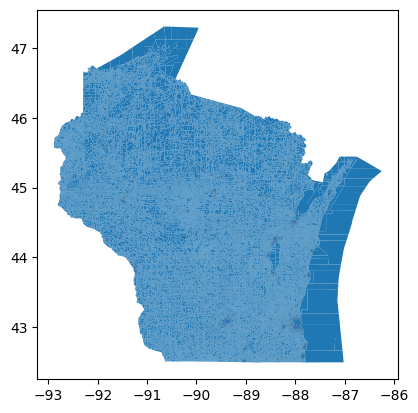

In [13]:
state_blocks.plot()

In [14]:
state_block_polygons = prep_state_block_data_for_graph(state_blocks, national_cong_bef, national_st_leg_upper_bef, national_st_leg_lower_bef)

Here we visualize Wisconsin's Census blocks, excluding unassigned blocks, colored by State Senate district.

<Axes: >

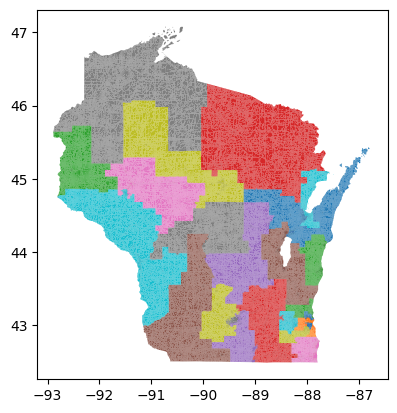

In [15]:
state_block_polygons[state_block_polygons['ST_Leg_Upper'] != exclude_codes['ST_Leg_Upper']].plot(column = 'ST_Leg_Upper')

Next we make the block adjacency graphs. In this example we require Rook adjacency to define edges in our graph.  Setting contig_type = 'Queen' would instead allow edges to be defined by queen adjacency.

In [16]:
rook_nodes, rook_adj = get_block_graph_data(state_block_polygons, contig_type = 'Rook', chambers = ['Congressional','ST_Leg_Upper','ST_Leg_Lower',])

In [17]:
print(f"{state_name}'s rook-adjacent Census block graph has {len(rook_nodes)} nodes and {len(rook_adj)} edges")

Wisconsin's rook-adjacent Census block graph has 203069 nodes and 494610 edges


Finally for each districting plan in Wisconsin, we determine the number of discontiguous districts

In [18]:
for chamber in ['Congressional','ST_Leg_Upper','ST_Leg_Lower']:
    dist_contiguity = num_concomp_per_dist(rook_nodes, rook_adj,chamber, exclude_codes[chamber])
    num_dicontig_dists = sum([v>1 for v in dist_contiguity.values()])
    num_dists = len(dist_contiguity)
    print(f"{state_name}'s {chamber} Districting Plan has {num_dicontig_dists} (of {num_dists}) Rook-Discontiguous Districts")

Wisconsin's Congressional Districting Plan has 0 (of 8) Rook-Discontiguous Districts
Wisconsin's ST_Leg_Upper Districting Plan has 21 (of 33) Rook-Discontiguous Districts
Wisconsin's ST_Leg_Lower Districting Plan has 54 (of 99) Rook-Discontiguous Districts
